In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import random
import scipy.io as sio
from scipy.signal import argrelmax
from scipy.spatial import distance_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
# Read in the data from the labeled spectrum file
file_name = 'Labeled Data/8-27-18 A3D16F3 slide 2 brain 1.mat'
f = h5py.File(file_name, 'r')
data = {}
for k, v in f.items():
    data[k] = np.array(v)
print (f.items())

ItemsViewHDF5(<HDF5 file "8-27-18 A3D16F3 slide 2 brain 1.mat" (mode r)>)


In [3]:
# View the titles of the data sets included in the file
[(k,v) for k,v in f.items()]

[('#refs#', <HDF5 group "/#refs#" (31 members)>),
 ('ROI', <HDF5 dataset "ROI": shape (2, 5), type "|O">),
 ('ROIcount', <HDF5 dataset "ROIcount": shape (1, 1), type "<f8">),
 ('img', <HDF5 dataset "img": shape (69088, 140, 43), type "<f8">),
 ('imgX', <HDF5 dataset "imgX": shape (140, 1), type "<f8">),
 ('imgY', <HDF5 dataset "imgY": shape (43, 1), type "<f8">),
 ('imgZ', <HDF5 dataset "imgZ": shape (1, 69088), type "<f8">)]

Brain images at m/z value of 834.5411880484747


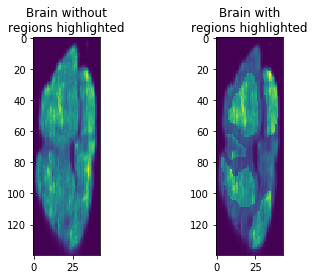

Pixel counts in regions:
left cortex: 328 pixels in region
right cortex: 283 pixels in region
middle: 152 pixels in region
left caudoputamen: 417 pixels in region
right caudoputamen: 532 pixels in region

Total pixels in image: 6020


In [4]:
# Get the regions from the labeled data file
region_count = int(data["ROIcount"])
regions = [np.array([x for x in f[data["ROI"][1,i]]]) for i in range(region_count)]

# Display the brain by displaying abundances at the m/z value that maximizes
# the abundance at a pixel within the body of the brain
pixel = (20,20)
brain_image = data['img'][np.argmax(data['img'][:,pixel[0],pixel[1]]),:,:]
print("Brain images at m/z value of",
        data["imgZ"][0][np.argmax(data['img'][:,pixel[0],pixel[1]])])
plt.subplot(121).imshow(brain_image)
plt.subplot(121).set_title("Brain without\nregions highlighted")
plt.subplot(122).imshow(brain_image + np.multiply(brain_image, sum(regions)))
plt.subplot(122).set_title("Brain with\nregions highlighted")
plt.show()

# Initialize containers for the region names and assigned colors
region_names = []
colors = ['k', 'r', 'y', 'g', 'b']

# Determine region names and amount of pixels in each region
print("Pixel counts in regions:")
for i in range(region_count):
    region_names.append(''.join([chr(x[0]) for x in f[data["ROI"][0,i]]]))
    print(region_names[-1], end=": ")
    print(sum(sum(regions[i])), "pixels in region")

# Output the total amount of pixels in the image
shape = data["img"].shape
print("\nTotal pixels in image:", shape[1]*shape[2])

In [5]:
xSize, ySize, zSize= data['img'].shape
n = 0
census_maxima = set([])

for i in range(ySize):
    for j in range(zSize):
        spectrum = data['img'][:,i,j]
        maxima = argrelmax(spectrum)[0]
        maxima = maxima[spectrum[maxima] > 1000]
        sort = np.argsort(spectrum[maxima])[-100:]
        maxima = maxima[sort]
        census_maxima = census_maxima.union(set(maxima))
        
        if n % 100 == 0:
            print("Finished reading", n, "out of", ySize*zSize, "rows", end="\r")
            
        n += 1

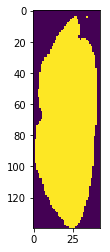

In [6]:
plt.imshow(brain_image > 7300)
labels = np.array([None]*n)
numbered_labels = np.array([-1]*n)

In [7]:
print(len(census_maxima))
maxima_list = np.array(sorted(census_maxima))

2318


In [8]:
spectra = np.zeros((n, len(maxima_list)))
s = 0

for i in range(ySize):
    for j in range(zSize):
        spectra[s] = data['img'][:,i,j][maxima_list]
        labeled = False
        for r in range(region_count):
            if regions[r][i,j] == 1:
                labels[s] = region_names[r]
                numbered_labels[s] = r
                labeled = True
        if not labeled:
            labels[s] = ("brain other" if brain_image[i,j] > 7300 else "not brain")
            numbered_labels[s] = (5 if brain_image[i,j] > 7300 else 6)
        
        if s % 100 == 0:
            print("Finished reading", s, "out of", ySize*zSize, "rows", end="\r")
            
        s += 1

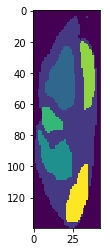

In [9]:
plt.imshow(6 - numbered_labels.reshape(ySize, zSize))

In [10]:
class PCA:
    def __init__(self, X, s=None):
        self.X = X - np.mean(X)
        U, S, V_t = np.linalg.svd(self.X)
        self.V = V_t.T
        self.Sigma = S
        self.s = (s if s else len(X.T))
    
    def variance(self):
        return self.Sigma**2
    
    def transform(self, new):
        self.transformation = self.V[:,:self.s].T @ new
        return self.transformation
    
    def project(self, new_x):
        return sum([self.transformation[i]*self.V[:,i] for i in range(self.s)])

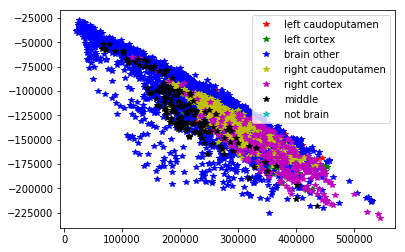

In [11]:
X = spectra[labels != "not brain"]
y = labels[labels != "not brain"]
pca = PCA(X)
pca.variance()

transformations = []
for row in X:
    transformations.append(pca.transform(row))
transformations = -1*np.array(transformations)

labels_list = list(set(labels))
filters = [y==u for u in labels_list]
colors, c = ['r', 'g', 'b', 'y', 'm', 'k', 'c'], 0
for f in filters:
    plt.plot(transformations[:,0][f], transformations[:,1][f], colors[c]+'*',
            label=labels_list[c])
    c += 1
plt.legend()
plt.show()

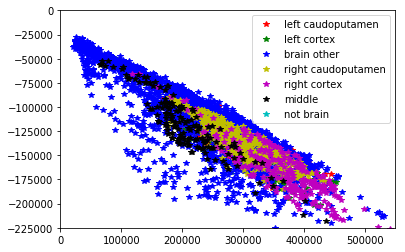

In [12]:
labels_list = list(set(labels))
filters = [y==u for u in labels_list]
colors, c = ['r', 'g', 'b', 'y', 'm', 'k', 'c'], 0
for f in filters:
    plt.plot(transformations[:,0][f], transformations[:,1][f], colors[c]+'*',
            label=labels_list[c])
    plt.xlim(0,550000)
    plt.ylim(-225000, 0)
#     plt.legend()
#     plt.show()
    c += 1
plt.legend()
plt.show()

In [53]:
labels[labels == 'right caudoputamen'] = 'caudoputamen'
labels[labels == 'left caudoputamen'] = 'caudoputamen'
labels[labels == 'right cortex'] = 'cortex'
labels[labels == 'left cortex'] = 'cortex'

spectra_ = np.hstack((spectra, np.array([list(range(0, spectra.shape[0]))]).T))
X = spectra_[labels != "not brain"]
y = labels[labels != "not brain"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.70,
        random_state=1)
print(len(y_train), len(y_test))
for solver in ['newton-cg']: # , 'sag', 'lbfgs']:
    clf = LogisticRegression(random_state=1, solver=solver,
            multi_class='multinomial').fit(x_train, y_train)
    prediction = clf.predict(x_test)
    mistakes = len(y_test[prediction != y_test])
    print('Using the', solver, 'solver, there were', mistakes, 'mistakes',
         'out of', len(y_test), 'data points.')

1192 2783
Using the newton-cg solver, there were 178 mistakes out of 2783 data points.


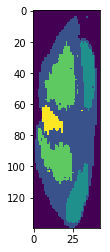

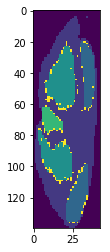

In [93]:
str_to_num = {'brain other':1, 'cortex':2, 'caudoputamen':3, "middle":4}
image = np.zeros(spectra.shape[0])
last = int(spectra.shape[1])
for i in range(len(y_train)):
    image[int(x_train[i,last])] = str_to_num[y_train[i]]
for i in range(len(y_test)):
    image[int(x_test[i,last])] = str_to_num[prediction[i]]
plt.imshow(image.reshape(shape[1:]))
plt.show()
for i in x_test[prediction != y_test, spectra.shape[1]].astype(int):
    image[i] = 6
plt.imshow(image.reshape(shape[1:]))
plt.show()